### This memo demonstrates two ways to separate on and off data recorded with Chopper 

1. Subtract the mean from the spectra to center data around mean. Classify >0 as on and <0 as off. 
2. Identify transition indices by finding the difference between adjacent points 

In [1]:
%matplotlib notebook
import numpy as np
import pandas as pd 
import glob
import scipy
from scipy import signal
import matplotlib.pyplot as plt
from astropy.time import Time

In [2]:
#functions to read fieldfox files 
def read_fieldfox(file):
    data = np.array(pd.read_csv(file,skiprows = 32))
    freq = data[:-1,0].astype(float)
    power= data[:-1,1].astype(float)
    return freq, power

def read_rtsa_file(rx_files):
    final_df = []
    for file in rx_files:
        data = pd.read_csv(file,skiprows = 17,header=None)
        data=data.drop([0,2,3,4],axis=1)
        with open(file,'r') as f:
            for i,line in enumerate(f):
                if 'Freq Hz' in line:
                    break
        cols=line.split(',')[5:]
        cols = ['Datetime'] + cols
        data.columns=cols
        final_df.append(data)  
    return pd.concat(final_df,ignore_index=True)

In [3]:
#tx with 30dB att on 
ch_att_30 = glob.glob('chopper_valon_30dB_att/*.csv')
ch_att_30_df = read_rtsa_file(ch_att_30)

/home/mrudula/.local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3337: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


<IPython.core.display.Javascript object>


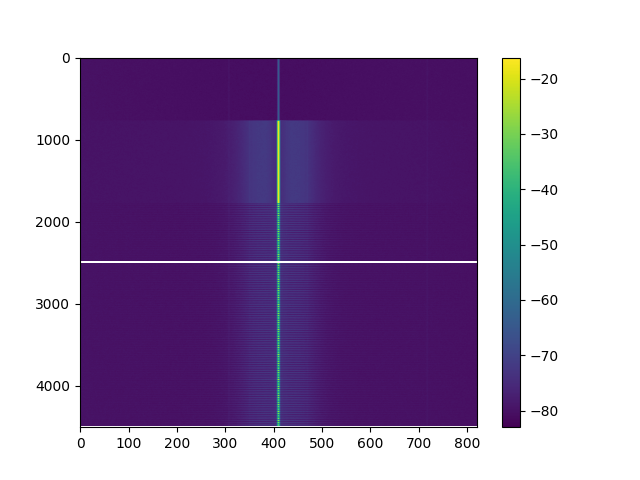

In [4]:
plt.figure()
plt.imshow(ch_att_30_df.iloc[:, 1:], aspect = 'auto')
plt.colorbar()

<IPython.core.display.Javascript object>


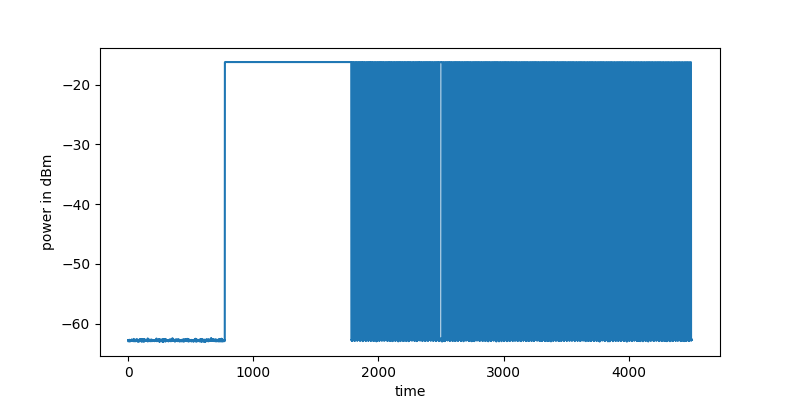

Text(0, 0.5, 'power in dBm')

In [6]:
plt.figure(figsize = (8,4))
plt.plot(ch_att_30_df.iloc[:,411].values)
plt.xlabel('time')
plt.ylabel('power in dBm')

In [7]:
ch_att_30_df['Datetime'] = pd.to_datetime(ch_att_30_df['Datetime'])

In [8]:
#creating a subset of alternating mode data
ex = pd.DataFrame({'a':ch_att_30_df.iloc[2000:, 0],'b':ch_att_30_df.iloc[2000:,411], 
                   'c': ch_att_30_df.iloc[2000:,411] - np.mean(ch_att_30_df.iloc[2000:,411])})

In [9]:
ex['d'] = np.where(ex['c'] > 0,1,0)

<IPython.core.display.Javascript object>


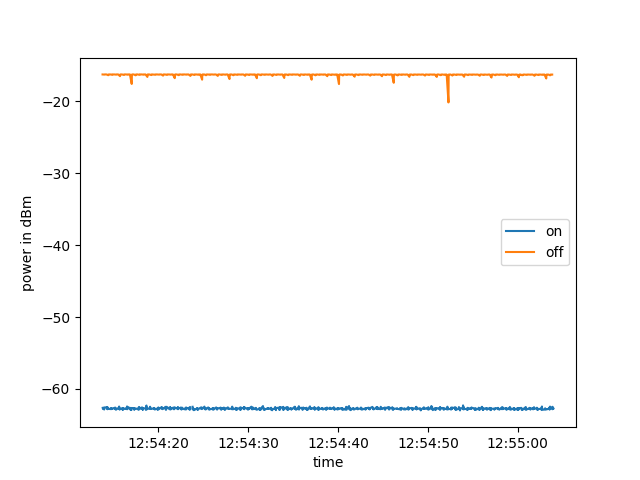

In [10]:
plt.figure()
plt.plot(ex['a'][ex['d'] == 0], ex['b'][ex['d'] == 0], label = 'on')
plt.plot(ex['a'][ex['d'] == 1], ex['b'][ex['d'] == 1], label = 'off')
plt.xlabel('time')
plt.ylabel('power in dBm')
plt.legend()

In [11]:
#trying this technique when SNR is lower
ch_att_80 = glob.glob('chopper_valon_80dB_att/*.csv')
ch_att_80_df = read_rtsa_file(ch_att_80)
ch_att_80_df['Datetime'] = pd.to_datetime(ch_att_80_df['Datetime'])

/home/mrudula/.local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3337: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


<IPython.core.display.Javascript object>


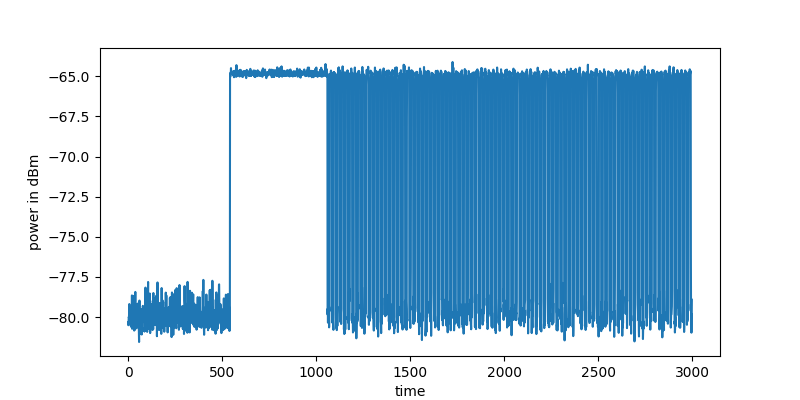

Text(0, 0.5, 'power in dBm')

In [12]:
plt.figure(figsize = (8,4))
plt.plot(ch_att_80_df.iloc[:,411].values)
plt.xlabel('time')
plt.ylabel('power in dBm')

In [13]:
ex2 = pd.DataFrame({'a':ch_att_80_df.iloc[1070:, 0],'b':ch_att_80_df.iloc[1070:,411], 
                   'c': ch_att_80_df.iloc[1070:,411] - np.mean(ch_att_80_df.iloc[1070:,411])})
ex2['d'] = np.where(ex2['c'] > 0,1,0)

<IPython.core.display.Javascript object>


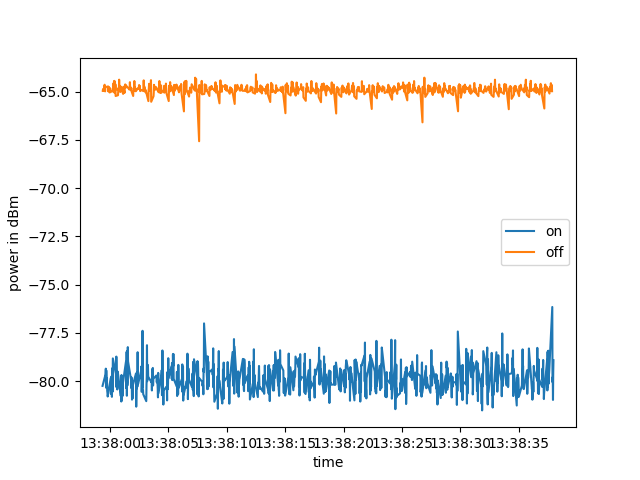

In [15]:
plt.figure()
plt.plot(ex2['a'][ex2['d'] == 0], ex2['b'][ex2['d'] == 0], label = 'on')
plt.plot(ex2['a'][ex2['d'] == 1], ex2['b'][ex2['d'] == 1], label = 'off')
plt.xlabel('time')
plt.ylabel('power in dBm')
plt.legend()

### Identifying transition indices 

(current logic sensitive to breaks in the data) 

In [16]:
ex2['e'] = ex2['b'] - ex2['b'].shift(1)
ex2['e']=ex2['e'].fillna(0)
transition_indices = ex2.index[abs(ex2['e']) > 7] 

In [17]:
on_vals=[]
on_vals_indx=[]
off_vals=[]
i = 0
flag= False
while i < len(transition_indices)-1:
    if not flag:
        on_vals += ex2['b'].loc[transition_indices[i]  : transition_indices[i+1]-1].tolist()
        on_vals_indx+= ex2['b'].loc[transition_indices[i] : transition_indices[i+1]-1].index.tolist()
        flag=True
    else:
        off_vals += ex2['b'].loc[transition_indices[i] : transition_indices[i+1]-1].tolist()
        flag=False

    i+=1

<IPython.core.display.Javascript object>


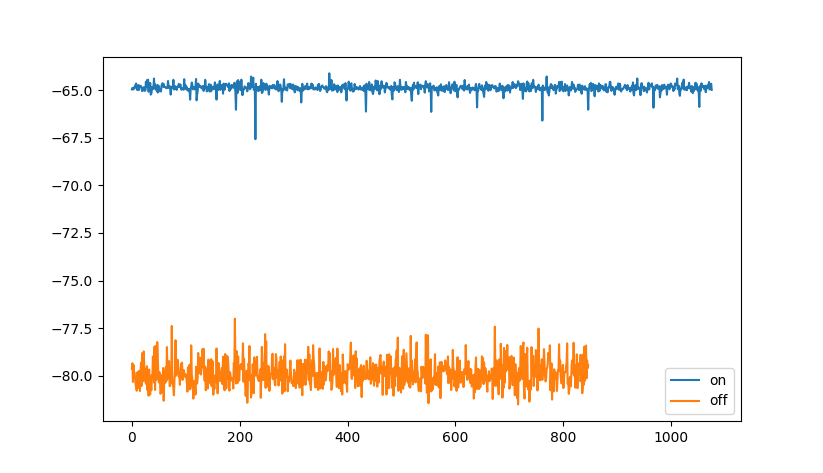

In [18]:
plt.figure()
plt.plot(on_vals, label = 'on')
plt.plot(off_vals, label = 'off')
plt.legend()